In [122]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import layers, models

In [75]:
# constant
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [76]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [77]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [78]:
len(dataset)

68

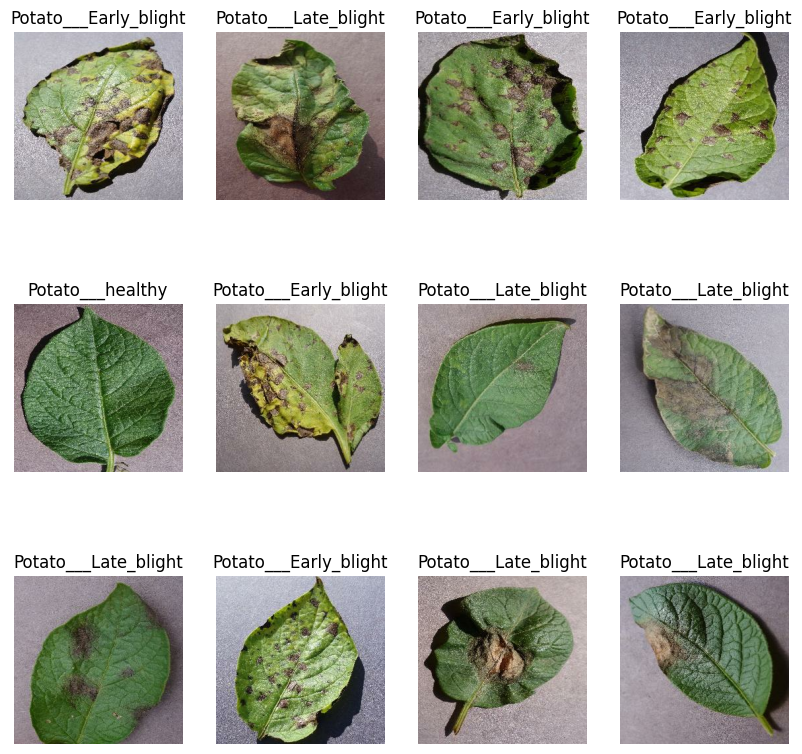

In [79]:
plt.figure(figsize=(10,10))
for images_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [80]:
# 80% ==> training data (54)
# 20% ==> 10% validation (6), 10% test (8)

train_size = 0.8

train_ds = dataset.take(54)
test_ds = dataset.skip(54)

In [81]:
val_size = 0.1

val_ds = test_ds.take(6)

In [82]:
test_ds = test_ds.skip(6)

In [83]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [84]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [85]:
len(train_ds)

54

In [86]:
len(val_ds)

6

In [87]:
len(test_ds)

8

In [88]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [89]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [90]:
data_augmentation = resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [91]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes =3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    # cnn
    layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),

    # dense
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

model.build(input_shape=input_shape)

In [92]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [93]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [97]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 54s 997ms/step - loss: 0.0486 - accuracy: 0.9890 - val_loss: 0.0143 - val_accuracy: 0.9948
Epoch 2/50
54/54 [==============================] - 29s 547ms/step - loss: 0.0091 - accuracy: 0.9983 - val_loss: 0.0069 - val_accuracy: 0.9948
Epoch 3/50
54/54 [==============================] - 28s 515ms/step - loss: 0.0651 - accuracy: 0.9774 - val_loss: 0.0117 - val_accuracy: 0.9948
Epoch 4/50
54/54 [==============================] - 28s 512ms/step - loss: 0.0325 - accuracy: 0.9913 - val_loss: 0.0130 - val_accuracy: 0.9948
Epoch 5/50
54/54 [==============================] - 29s 529ms/step - loss: 0.0298 - accuracy: 0.9878 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 6/50
54/54 [==============================] - 29s 530ms/step - loss: 0.0236 - accuracy: 0.9925 - val_loss: 0.0352 - val_accuracy: 0.9792
Epoch 7/50
54/54 [==============================] - 28s 521ms/step - loss: 0.0530 - accuracy: 0.9821 - val_loss: 0.0306 - val_accuracy: 0.9896

In [98]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 224ms/step - loss: 0.0024 - accuracy: 1.0000


In [99]:
scores

[0.002350462134927511, 1.0]

In [100]:
history

In [101]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [104]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [106]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training and Validation Loss')

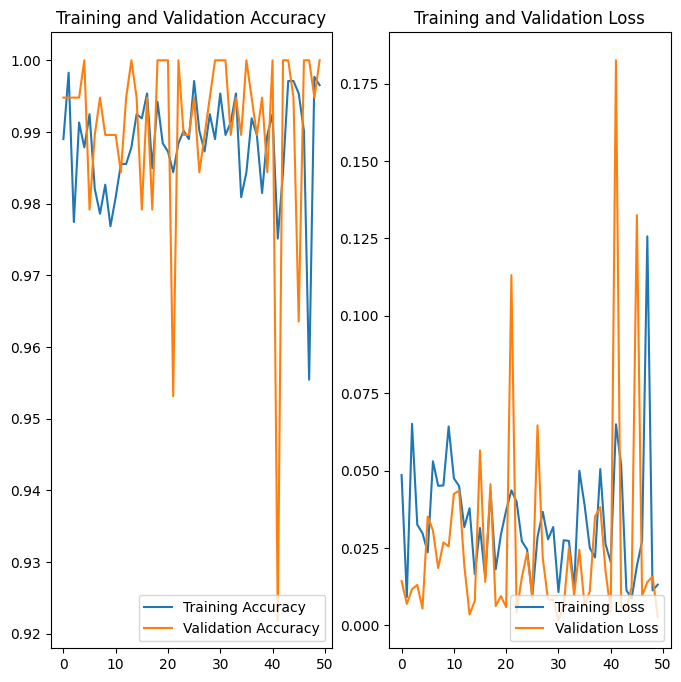

In [110]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Training and Validation Loss")

first image to predict
actual label:  Potato___Early_blight
1/1 [==============================] - 0s 338ms/step
predicted label:  Potato___Early_blight


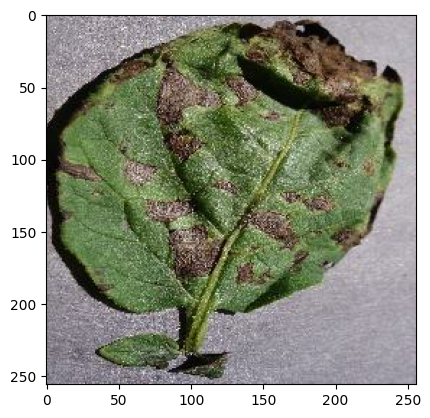

In [125]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label: ", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label: ", class_names[np.argmax(batch_prediction[0])])

In [126]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


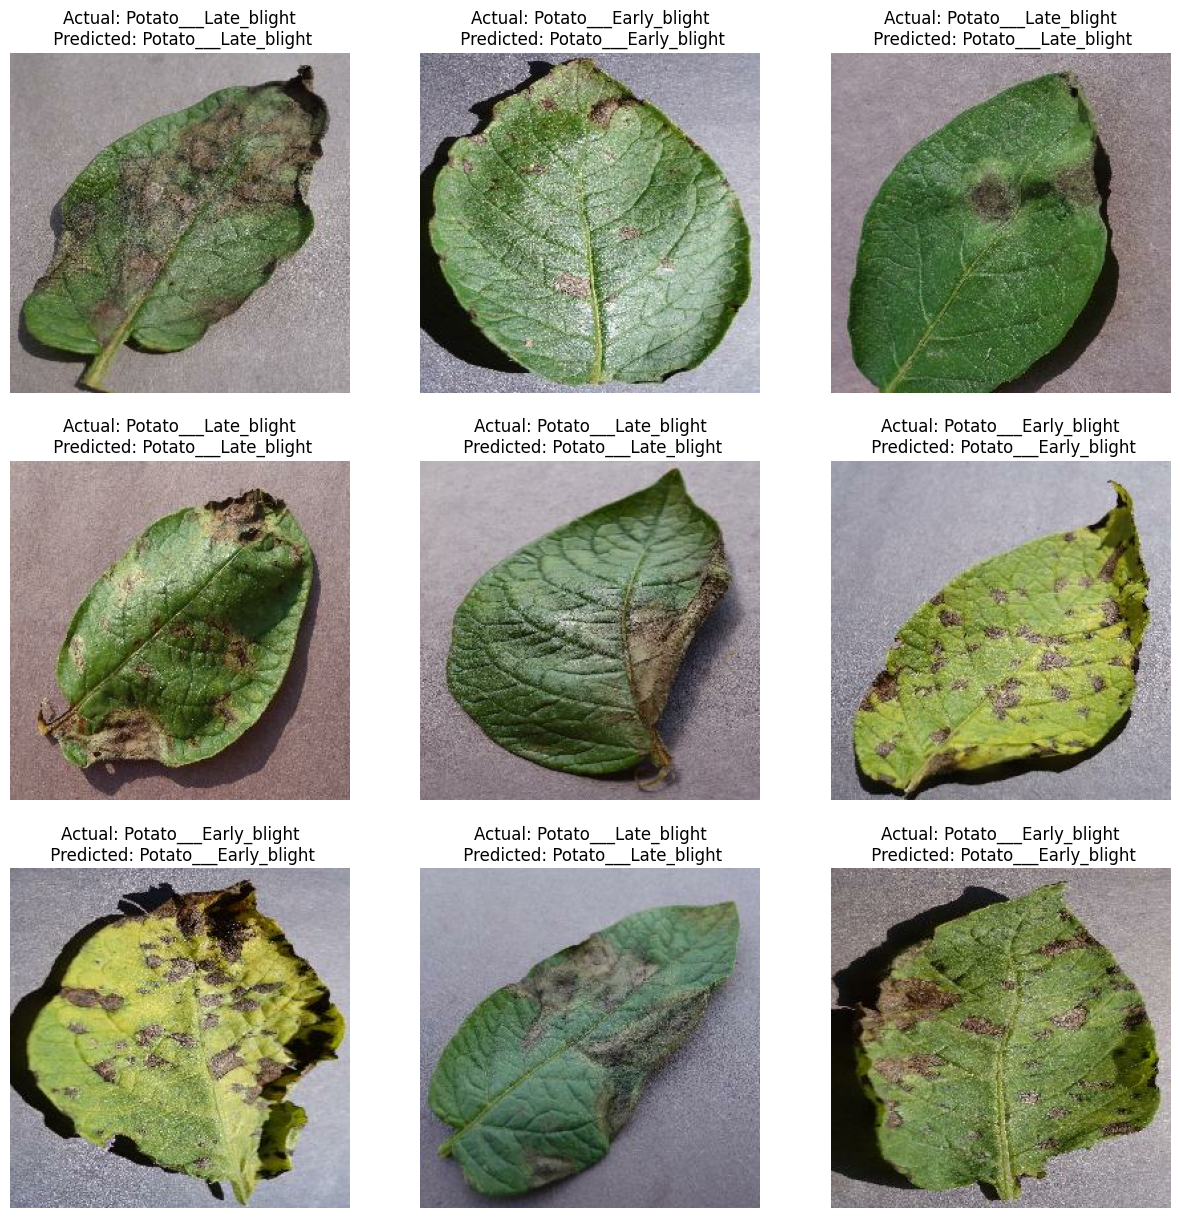

In [130]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax =plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy)
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}")
        
        plt.axis("off")

In [132]:


model_version =1
model.save(f"./model/{model_version}")

INFO:tensorflow:Assets written to: ./model/1\assets


INFO:tensorflow:Assets written to: ./model/1\assets
